In [12]:
import os
import pathlib
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import wfutils
import tensorflow_hub as hub
from tensorflow.keras import layers

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-07-26 16:09:38.076766: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-26 16:09:38.240432: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-26 16:09:38.240498: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
data_path = Path("../data/smalldataset")

# Setup train and testing paths
train_dir = Path(data_path, "train")
test_dir = Path(data_path, "test")
val_dir = Path(data_path, "val")

train_dir, test_dir, val_dir

(PosixPath('../data/smalldataset/train'),
 PosixPath('../data/smalldataset/test'),
 PosixPath('../data/smalldataset/val'))

In [4]:
data_dir = pathlib.Path(train_dir) 
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Achillea_millefolium' 'Aconitum_columbianum' 'Allium_acuminatum'
 'Allium_cernuum' 'Amelanchier_alnifolia' 'Androsace_septentrionalis'
 'Antennaria_rosea' 'Anticlea_elegans' 'Aquilegia_coerulea'
 'Caltha_leptosepala' 'Campanula_rotundifolia' 'Cardus_nutans'
 'Castilleja_linariifolia' 'Castilleja_rhexifolia'
 'Castilleja_septentrionalis' 'Chamaenerion_angustifolium'
 'Clematis_hirsutissima' 'Corydalis_caseana' 'Dasiphora_fruticosa'
 'Delphinium_barbeyi' 'Eremogone_fendleri' 'Erigeron_coulteri'
 'Erigeron_divergens' 'Erigeron_flagellaris' 'Erigeron_speciosus'
 'Eriogonum_umbellatum' 'Eriogonum_umbellatum_var_majus'
 'Erythronium Grandiflorum' 'Frasera_speciosa' 'Gentiana_parryi'
 'Geranium_richardsonii' 'Geum_triflorum' 'Heterotheca_villosa'
 'Hymenoxys_hoopesii' 'Ipomopsis_aggregata' 'Ligusticum_porteri'
 'Lupinus_argenteus' 'Mertensia_ciliata' 'Nuphar_polysepala'
 'Paxistima_myrsinites' 'Pedicularis_bracteosa' 'Pedicularis_groenlandica'
 'Pedicularis_racemosa' 'Penstemon_mensarum' 'P

In [5]:
num_classes = len(class_names)
num_classes

66

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# Set the random seed
random_seed = 42
tf.random.set_seed(random_seed)

# Normalize all pixel values using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Get the data from our train and test directories

batch_size = 32

# If we use flow() we would need to fit, but I believe this works
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=batch_size,           # number of images to process at a time 
                                               target_size=(224, 224),  # convert all images to be 224 x 224
                                               class_mode="categorical",     # type of problem we're working on
                                               seed=42)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=batch_size,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)
val_data = test_datagen.flow_from_directory(val_dir,
                                               batch_size=batch_size,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 5308 images belonging to 66 classes.
Found 1718 images belonging to 66 classes.
Found 1718 images belonging to 66 classes.


In [9]:
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils

def predict_random_image(model, target_dir, class_names):

    #print("Target Dir: ", target_dir)
    i =0
    random_folder_str = random.sample(os.listdir(target_dir), 1)[0]
    random_folder = os.path.join(target_dir, random_folder_str)
    while not os.path.isdir(random_folder): 
        # print("random folder/file", random_folder.as_posix())
        i+=1
        random_folder_str = random.sample(os.listdir(target_dir), 1)[0]
        random_folder = os.path.join(target_dir, random_folder_str)
        if i > 10 :
            break
    #print("RandomFolder", random_folder)
    # Get a random image path
    random_image = random.sample(os.listdir(random_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(random_folder + "/" + random_image[0])
    ##plt.imshow(img)
    plt.title(random_folder)
    plt.axis("off")

    #resize and reshape
    image = image_utils.load_img(random_folder + "/" + random_image[0], color_mode="rgb", target_size=(224,224)) 
    plt.imshow(image)   
    image = image_utils.img_to_array(image)
    print(f"Image shape: {image.shape}") # show the shape of the image
    
    image = image/255 # normalize
    image = image.reshape(1, 224, 224, 3) # reshape
    print(f"Image shape: {image.shape}") # show the shape of the image
    prediction = model.predict(image)
    print("Prediction: ", class_names[np.argmax(prediction[0])])

    return prediction

In [10]:
#use efficientnet
en_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"

In [13]:

feature_extractor_layer = hub.KerasLayer(en_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=( 224, 224, 3)) # define the input image shape


en_model = tf.keras.Sequential([
    feature_extractor_layer,
    Dense(num_classes, activation='softmax')
])

In [15]:
en_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [17]:
en_history = en_model.fit(train_data,
                            epochs=5,
                            steps_per_epoch=len(train_data),
                            validation_data=val_data,
                            validation_steps=len(val_data))

Epoch 1/5


2024-07-26 16:12:20.100581: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-07-26 16:12:21.042267: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdeb0c0ec50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-26 16:12:21.042311: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2024-07-26 16:12:21.068954: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1722031941.215333   44364 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


166/166 [==============================] - 21s 83ms/step - loss: 2.3903 - accuracy: 0.5175 - val_loss: 1.3359 - val_accuracy: 0.7841
Epoch 2/5
166/166 [==============================] - 14s 82ms/step - loss: 0.9829 - accuracy: 0.8308 - val_loss: 0.8543 - val_accuracy: 0.8376
Epoch 3/5
166/166 [==============================] - 11s 67ms/step - loss: 0.6279 - accuracy: 0.8904 - val_loss: 0.6708 - val_accuracy: 0.8725
Epoch 4/5
166/166 [==============================] - 9s 52ms/step - loss: 0.4601 - accuracy: 0.9211 - val_loss: 0.5632 - val_accuracy: 0.8830
Epoch 5/5
166/166 [==============================] - 9s 53ms/step - loss: 0.3538 - accuracy: 0.9489 - val_loss: 0.5037 - val_accuracy: 0.8923


In [18]:
def plot_loss_accuracy_curves(history):
    # Plot the training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


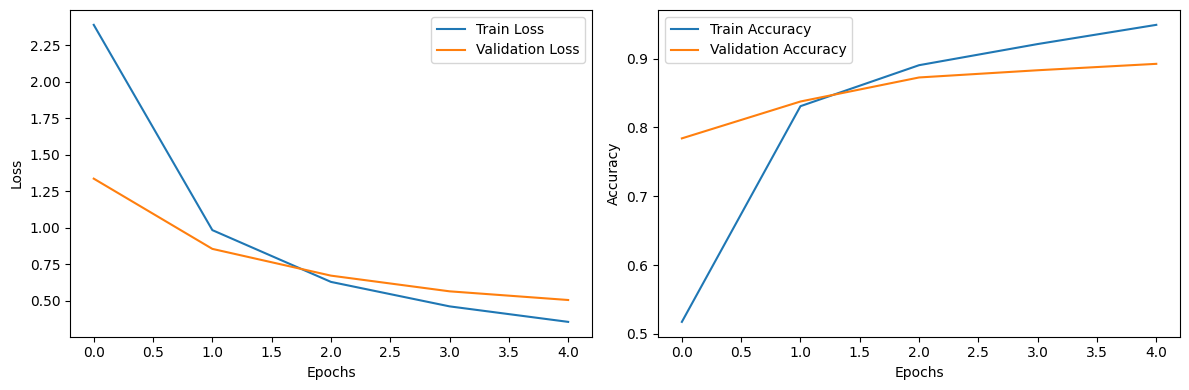

In [19]:
plot_loss_accuracy_curves(en_history)

Image shape: (224, 224, 3)
Image shape: (1, 224, 224, 3)
1/1 [==============================] - 1s 1s/step
Prediction:  Delphinium_barbeyi


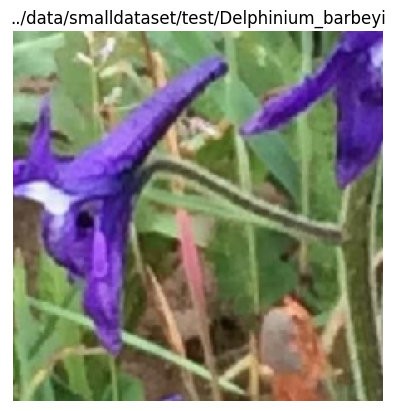

In [20]:
pred = predict_random_image(en_model, test_dir, class_names)

Image shape: (224, 224, 3)
Image shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 27ms/step
Prediction:  Clematis_hirsutissima


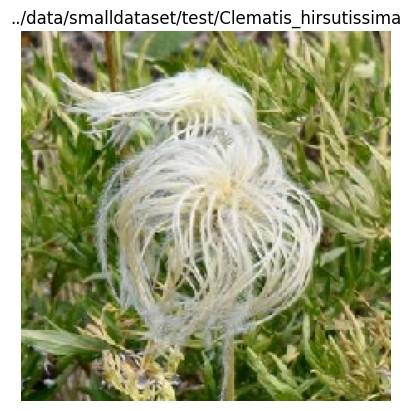

In [21]:
pred = predict_random_image(en_model, test_dir, class_names)

Image shape: (224, 224, 3)
Image shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 26ms/step
Prediction:  Mertensia_ciliata


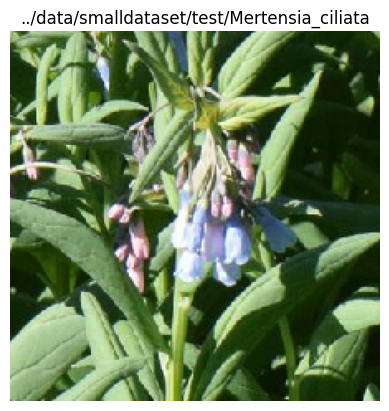

In [22]:
pred = predict_random_image(en_model, test_dir, class_names)

Let's finish it here.  It seems that in many cases, using existing SOTA models can at least provide a really good starting point for our day to day models.  
I really did not think that this would work as well as it did.